In [26]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

In [3]:
df = pd.read_json('recipies.json')


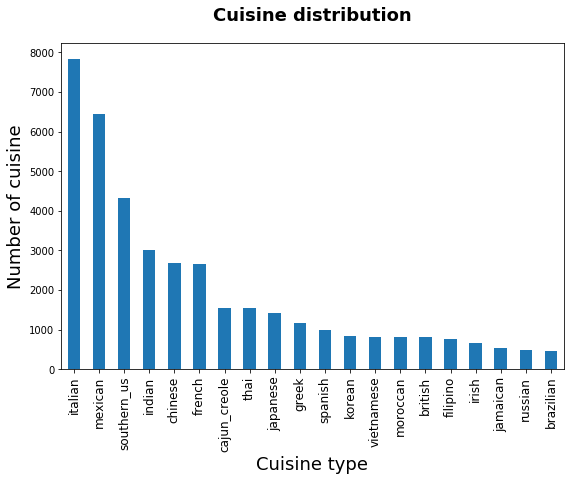

In [4]:
plt.figure(figsize=(9,6))
df.cuisine.value_counts().plot(kind = 'bar')


plt.xlabel('Cuisine type',fontsize = 18)
plt.ylabel('Number of cuisine',fontsize = 18)


plt.xticks(fontsize=12,rotation=90)

plt.title('Cuisine distribution', y=1.05, fontsize=18,fontweight='bold') 
plt.savefig('cuisine.png',  bbox_inches = 'tight')

# nltk

In [5]:
###find the important gradient by word frequency

In [6]:
cui_list = df.cuisine.unique()

In [7]:
food = 'italian'

In [8]:
for item in cui_list:
    lirsh = df.ingredients[df.cuisine == item].tolist()
    total =  [x for j in lirsh for x in j]
    fdist = FreqDist(total)
    tops=fdist.most_common(10)
    print(item, tops, '\n' )


greek [('salt', 572), ('olive oil', 504), ('dried oregano', 267), ('garlic cloves', 254), ('feta cheese crumbles', 252), ('extra-virgin olive oil', 229), ('fresh lemon juice', 222), ('ground black pepper', 221), ('garlic', 216), ('pepper', 203)] 

southern_us [('salt', 2290), ('butter', 1255), ('all-purpose flour', 1222), ('sugar', 1054), ('large eggs', 746), ('baking powder', 729), ('water', 686), ('unsalted butter', 655), ('milk', 645), ('buttermilk', 634)] 

filipino [('salt', 421), ('garlic', 325), ('water', 310), ('onions', 310), ('soy sauce', 251), ('pepper', 199), ('oil', 166), ('sugar', 136), ('carrots', 128), ('ground black pepper', 124)] 

indian [('salt', 1934), ('onions', 1195), ('garam masala', 862), ('water', 820), ('ground turmeric', 728), ('garlic', 726), ('cumin seed', 697), ('ground cumin', 683), ('vegetable oil', 593), ('oil', 546)] 

jamaican [('salt', 332), ('onions', 173), ('water', 153), ('garlic', 139), ('ground allspice', 128), ('pepper', 125), ('scallions', 11

In [9]:
lirsh = df.ingredients[df.cuisine == food].tolist()

total =  [x for j in lirsh for x in j if x!='salt']

fdist = FreqDist(total)
tops=fdist.most_common(10)

In [10]:
xxx = [tops[i][0] for i in range(10)]
yyy = [tops[i][1] for i in range(10)]

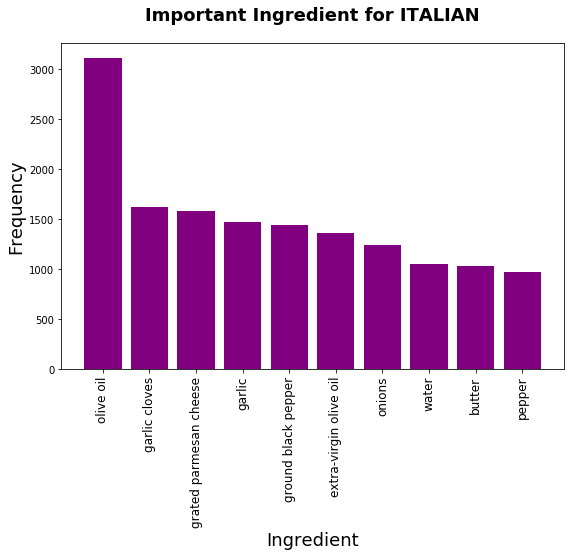

In [28]:
### plot important ingredient for Italian
plt.figure(figsize=(9,6))
plt.bar(xxx, yyy, color='purple')

plt.xlabel('Ingredient',fontsize = 18)
plt.ylabel('Frequency',fontsize = 18)

plt.xticks(fontsize=12,rotation=90)

plt.title('Important Ingredient for {}'.format(food.upper()), y=1.05, fontsize=18,fontweight='bold') 
plt.savefig('importance_nltk.png',  bbox_inches = 'tight')

# rf classification

In [12]:
###find the important ingredient by feature importance

In [13]:
allinone = df.ingredients.tolist()

In [14]:
total_all =  [x for j in allinone for x in j ]

In [15]:
name = list(set(total_all))

In [16]:
num = [str(i) for i in range(len(name))]

In [17]:
name_num = dict(zip(name, num))

In [18]:
def map_ingredient(info):
    at = [name_num[i] for i in info]
    at = ' '.join(item for item in at)
    return at

In [19]:
df['formated'] =df.ingredients.apply(map_ingredient)


In [20]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.9, ngram_range=(1, 1), max_features=300 )
### TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(df.formated)

In [21]:
X = tfidf.toarray()

In [22]:
y = df['cuisine'].apply(lambda x : x if x==food else 'other')

In [23]:
###split to training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

In [24]:
### Bayesian opt to tune hyperparameters
def rf_cv(n_estimators, min_samples_split, max_features, max_depth):
    val = cross_val_score(
        RandomForestClassifier(n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=min(max_features, 0.999), # float
            max_depth=int(max_depth),
            random_state=2
        ),
        X_train, y_train, scoring='roc_auc', cv=5
    ).mean()
    return val
    
### Run Bayesian optimization  
rf_bo = BayesianOptimization(
        rf_cv,
        {'n_estimators': (10, 250),
        'min_samples_split': (2, 25),
        'max_features': (0.1, 0.999),
        'max_depth': (5, 15)}
    )

In [50]:
rf_bo.maximize()

### output the optimal hyperparameters
rf_bo.max



|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.853    |  9.827    |  0.5112   |  21.1     |  80.64    |
|  2        |  0.8757   |  12.92    |  0.3659   |  15.45    |  105.6    |
|  3        |  0.8302   |  6.199    |  0.9701   |  8.533    |  112.2    |
|  4        |  0.8636   |  6.221    |  0.2599   |  4.112    |  180.2    |
|  5        |  0.8941   |  5.586    |  0.1032   |  6.527    |  242.9    |
|  6        |  0.832    |  5.766    |  0.5427   |  9.668    |  67.34    |
|  7        |  0.8559   |  11.48    |  0.5589   |  17.81    |  26.18    |
|  8        |  0.8621   |  14.32    |  0.5187   |  18.96    |  12.03    |
|  9        |  0.8642   |  13.16    |  0.616    |  21.94    |  80.75    |
|  10       |  0.8881   |  14.92    |  0.4144   |  24.61    |  241.3    |
|  11       |  0.8784   |  14.87    |  0.6287   |  2.101    |  245.1    |
|  12       |  0.8683   |  14.92    | 

{'params': {'max_depth': 14.999999998845997,
  'max_features': 0.1,
  'min_samples_split': 2.0000000161043894,
  'n_estimators': 131.83393831816315},
 'target': 0.912533521620589}

In [25]:
### define classifier and fitting data
forest = RandomForestClassifier(max_depth=15, max_features=0.1, min_samples_split=2, n_estimators=131)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features=0.1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=131,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [27]:
y_pred = forest.predict(X_test)
np.mean(cross_val_score(forest, X_train, y_train, cv=5, scoring='roc_auc'))

0.9122571225598287

In [29]:
### Features importances
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
feature_list = tfidf_vectorizer.get_feature_names()
ff = np.array(feature_list)


In [30]:
### list top 10 important features
final_index = [ff[item] for item in indices][:10]

In [31]:
imp_list = [list(name_num .keys()) [list (name_num .values()).index (item)] for item in final_index]

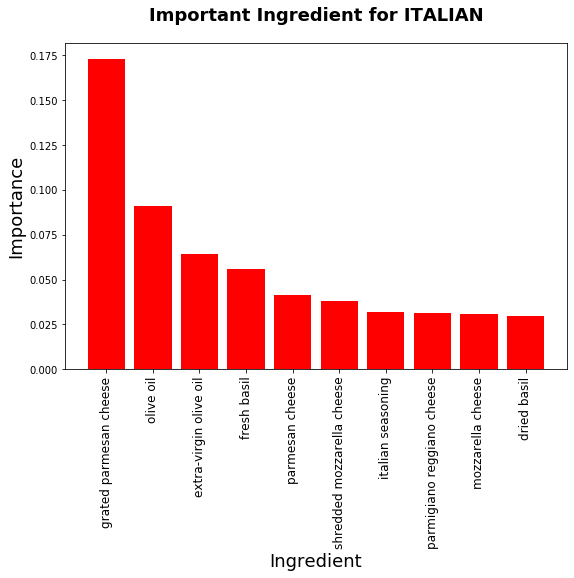

In [32]:
### plot important ingredient for Italian

plt.figure(figsize=(9,6))
plt.bar(imp_list, importances[indices[:10]], color='red')

plt.xlabel('Ingredient',fontsize = 18)
plt.ylabel('Importance',fontsize = 18)

plt.xticks(fontsize=12,rotation=90)

plt.title('Important Ingredient for {}'.format(food.upper()), y=1.05, fontsize=18,fontweight='bold') 
plt.savefig('importance_rf.png',  bbox_inches = 'tight')